In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()

# device = torch.device('cpu')
device = None
if use_gpu:
    device = torch.device('cuda:0')
    print("Using CUDA")
else:
    device = torch.device('cpu')
    print("Using CPU")
    
torch.manual_seed(54)

Using CUDA


In [2]:
# !pip install gputil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()  

 # ****Data preprocessing****

In [3]:
df = pd.read_csv('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
df.describe()

,Follow-up #,Patient ID,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [5]:
df.count()

Image Index                    112120
Finding Labels                 112120
Follow-up #                    112120
Patient ID                     112120
Patient Age                    112120
Patient Gender                 112120
View Position                  112120
OriginalImage[Width            112120
Height]                        112120
OriginalImagePixelSpacing[x    112120
y]                             112120
Unnamed: 11                         0
dtype: int64

In [6]:
df[df['Image Index'].isna()].count()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
Unnamed: 11                    0
dtype: int64

In [7]:
df[df['Finding Labels'] == 'No Finding'].count()

Image Index                    60412
Finding Labels                 60412
Follow-up #                    60412
Patient ID                     60412
Patient Age                    60412
Patient Gender                 60412
View Position                  60412
OriginalImage[Width            60412
Height]                        60412
OriginalImagePixelSpacing[x    60412
y]                             60412
Unnamed: 11                        0
dtype: int64

In [8]:
df = df.drop(df[df['Finding Labels'] == 'No Finding'].index)

In [9]:
labels = ['atelectasis', 'cardiomegaly', 'consolidation', 'edema', 'effusion', 'emphysema', 'fibrosis',
          'hernia', 'infiltration', 'mass', 'nodule', 'pleural_thickening', 'pneumonia', 'pneumothorax']

In [10]:
len(labels)

14

In [11]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,074Y,F,PA,2500,2048,0.168,0.168,NaN


In [12]:
df = df.drop(df.columns.difference(['Image Index', 'Finding Labels']), axis=1)

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
label_mlb = []
for label in df['Finding Labels'].values:
    splits = label.split('|')
    label_mlb.append(set(splits))

mlb = MultiLabelBinarizer()
label_array = mlb.fit_transform(label_mlb)

In [14]:
mlb.classes_

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [15]:
final_df = pd.DataFrame(label_array, columns=mlb.classes_)
final_df.insert(loc=0, column='Image', value=df['Image Index'].values)
final_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0







#  Creating dataset

In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [17]:

class ChestXRayDataset(Dataset):
    def __init__(self, root, df, transform=None):
        self.root = root
        self.df = df
        self.transform = transform
        
        file = open(self.root)
        images = file.read().splitlines()
        
        ids = []
        
        for idx, path in enumerate(self.df['Image']):
            if path in images:
                ids.append(idx)
        
        self.df = self.df.iloc[ids, :].reset_index(drop=True)
        self.images = self.df['Image'].values
        self.labels = self.df.iloc[:, 1:].values
    
        labels = list(map(lambda x: x.lower(), self.df.columns[1:]))
        self.classes = {v: k for k, v in enumerate(labels)}
        
    def __getitem__(self, item):
        img = Image.open(
            f'/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/{self.images[item]}'
        )
#         img = np.expand_dims(img, axis=-1)
#         img = img.repeat(3, axis=-1)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, torch.tensor(self.labels[item], dtype=torch.float32)
    
    def __len__(self):
        return len(self.df)

In [18]:
basic_transform = torchvision.transforms.Compose([
                                          torchvision.transforms.Grayscale(num_output_channels=3), 
                                          torchvision.transforms.Resize((299, 299)),
                                          torchvision.transforms.ToTensor()
                                          ])

In [19]:
train_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/train_val_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [20]:
test_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [21]:
len(train_dataset), train_dataset[0]

(36024,
 (tensor([[[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.

# Dealing with class imbalance

In [22]:
len(train_dataset)

36024

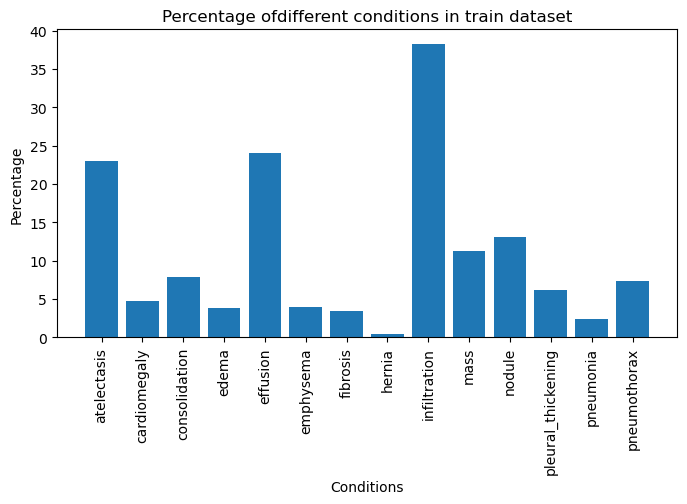

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_dataset.labels.sum(axis = 0)/len(train_dataset) * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

/tmp/ipykernel_29/1385432927.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


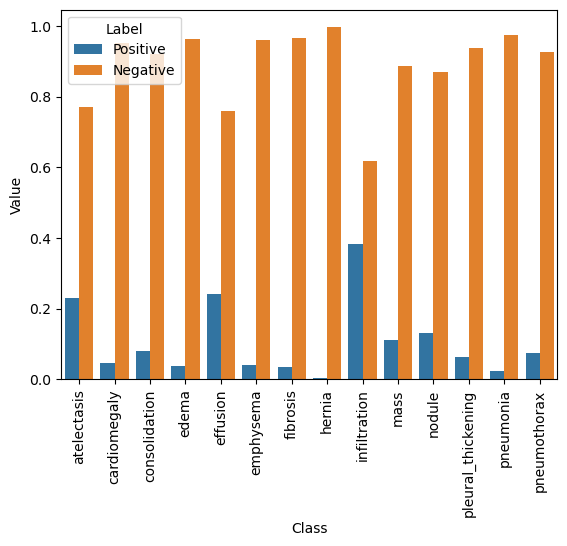

In [24]:
import seaborn as sns
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_dataset.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_29/1490179493.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


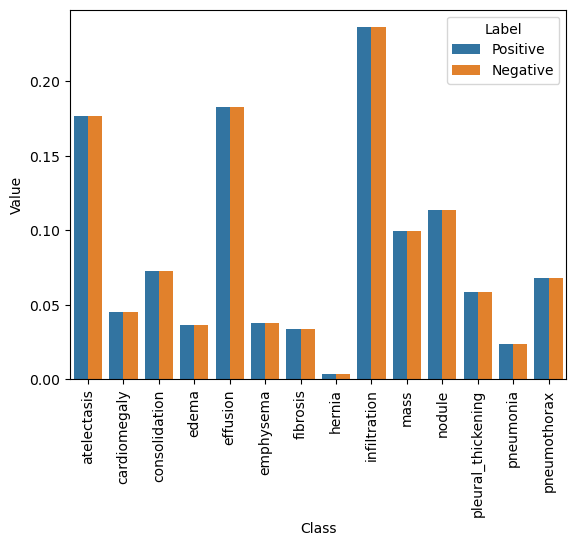

In [25]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [26]:
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()

    def forward(self, y_pred, y_true):
#         y_true = torch.LongTensor(y_true)
        loss = 0.0
        epsilon = 1e-9
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * torch.mean(neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

In [28]:
import random

from torch.utils.data.sampler import Sampler


class MultilabelBalancedRandomSampler(Sampler):
    """
    MultilabelBalancedRandomSampler: Given a multilabel dataset of length n_samples and
    number of classes n_classes, samples from the data with equal probability per class
    effectively oversampling minority classes and undersampling majority classes at the
    same time. Note that using this sampler does not guarantee that the distribution of
    classes in the output samples will be uniform, since the dataset is multilabel and
    sampling is based on a single class. This does however guarantee that all classes
    will have at least batch_size / n_classes samples as batch_size approaches infinity
    """

    def __init__(self, labels, indices=None, class_choice="least_sampled"):
        """
        Parameters:
        -----------
            labels: a multi-hot encoding numpy array of shape (n_samples, n_classes)
            indices: an arbitrary-length 1-dimensional numpy array representing a list
            of indices to sample only from
            class_choice: a string indicating how class will be selected for every
            sample:
                "least_sampled": class with the least number of sampled labels so far
                "random": class is chosen uniformly at random
                "cycle": the sampler cycles through the classes sequentially
        """
        self.labels = labels
        self.indices = indices
        # print(self.labels)
        if self.indices is None:
            self.indices = range(len(labels))

        self.num_classes = self.labels.shape[1]

        # List of lists of example indices per class
        self.class_indices = []
        for class_ in range(self.num_classes):
            lst = np.where(self.labels[:, class_] == 1)[0]
            lst = lst[np.isin(lst, self.indices)]
            self.class_indices.append(lst)

        self.counts = [0] * self.num_classes
        # print(self.counts)
        assert class_choice in ["least_sampled", "random", "cycle"]
        self.class_choice = class_choice
        self.current_class = 0
        # print(self.class_indices)

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count >= len(self.indices):
            raise StopIteration
        self.count += 1
        return self.sample()

    def sample(self):
        class_ = self.get_class()
        class_indices = self.class_indices[class_]
        chosen_index = np.random.choice(class_indices)
        if self.class_choice == "least_sampled":
            for class_, indicator in enumerate(self.labels[chosen_index]):
                if indicator == 1:
                    self.counts[class_] += 1
        return chosen_index

    def get_class(self):
        if self.class_choice == "random":
            class_ = random.randint(0, self.labels.shape[1] - 1)
        elif self.class_choice == "cycle":
            class_ = self.current_class
            self.current_class = (self.current_class + 1) % self.labels.shape[1]
        elif self.class_choice == "least_sampled":
            min_count = self.counts[0]
            min_classes = [0]
            for class_ in range(1, self.num_classes):
                if self.counts[class_] < min_count:
                    min_count = self.counts[class_]
                    min_classes = [class_]
                if self.counts[class_] == min_count:
                    min_classes.append(class_)
            class_ = np.random.choice(min_classes)
        return class_

    def __len__(self):
        return len(self.indices)

# Function that returns balanced accuracies, recall and precision

In [29]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.metrics import precision_score, recall_score

def get_classes_accuracy_and_pr(loader, model):
    model.eval()
    total_balanced_acc = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    y_true = []
    y_pred = []
    
    for images, labels in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        batch_balanced_accuracies = []

        np_labels = labels.cpu().detach().numpy()
        np_outputs = outputs.cpu().detach().numpy()
        for k in range(len(np_outputs)):
            for j in range(len(np_outputs[k])):
                np_outputs[k][j] = 1 if np_outputs[k][j] > THRESHOLD else 0

        y_true.extend(list(np_labels))
        y_pred.extend(list(np_outputs))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for i in range(len(outputs[0])):
        bal_acc = balanced_accuracy_score(y_true[:, i], y_pred[:, i])
        total_balanced_acc.append(bal_acc)
        
        precision = precision_score(y_true[:, i], y_pred[:, i])
        precision_scores.append(precision)
        
        recall = recall_score(y_true[:, i], y_pred[:, i])
        recall_scores.append(recall)
        
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1)
        
#         cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=mlb.classes)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                       display_labels=mlb.classes)
#         disp.plot()
            
#             bal_acc = balanced_accuracy_score(np_labels[:, i], np_outputs[:, i])
#             batch_balanced_accuracies.append(bal_acc)
#         total_balanced_acc.append(batch_balanced_accuracies)
    
#     mean_acc = np.mean(total_balanced_acc, axis=0)
#     print(len(total_balanced_acc))
#     print(mean_acc)
    return total_balanced_acc, precision_scores, recall_scores, f1_scores

In [30]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

BATCH_SIZE = 32
LEARNING_RATE = 1e-6
PIN_MEMORY = False
EPOCHS = 10
THRESHOLD = 0.5

In [31]:
print(DEVICE)

cuda


In [34]:
def train_epoch(loader, model, optimizer, loss_fn, epoch):
    model.train()
    
    losses = []
    i = 0
    running_loss = 0.
    for images, labels, in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
        i += 1
        
    print(f'=> Epoch[{epoch}]: Mean Loss = {np.mean(losses)}')
    torch.save(model.state_dict(), f'./weighted_bce_loss_weights{epoch}.pt')
    
    return np.mean(losses)

# Removing rare disease

In [35]:
labels = ['atelectasis', 'consolidation', 
          'effusion', 'infiltration','mass', 'nodule', 'pneumothorax']

In [36]:
cols_to_drop = ['Hernia', 'Pneumonia', 'Cardiomegaly', 'Fibrosis', 'Edema', 'Emphysema', 'Pleural_Thickening']
stripped_df = final_df.drop(columns=cols_to_drop)

In [37]:
stripped_df

,Image,Atelectasis,Consolidation,Effusion,Infiltration,Mass,Nodule,Pneumothorax
0,00000001_000.png,0,0,0,0,0,0,0
1,00000001_001.png,0,0,0,0,0,0,0
2,00000001_002.png,0,0,1,0,0,0,0
3,00000003_000.png,0,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
51703,00030786_007.png,0,1,0,0,0,0,0
51704,00030789_000.png,0,0,0,1,0,0,0
51705,00030793_000.png,0,0,0,0,1,1,0
51706,00030795_000.png,0,0,0,0,0,0,0


In [38]:
train_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/train_val_list_NIH.txt',
    df=stripped_df,
    transform=basic_transform
)

test_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt',
    df=stripped_df,
    transform=basic_transform
)

In [39]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    sampler=MultilabelBalancedRandomSampler(train_dataset.labels),
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=int(BATCH_SIZE/2),
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

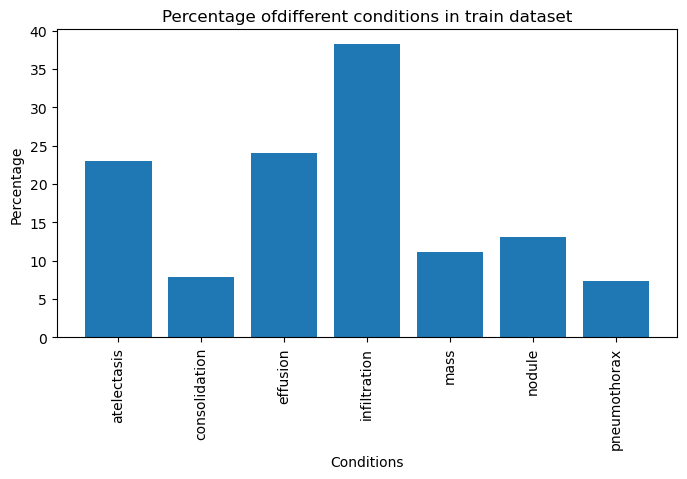

In [40]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_dataset.labels.sum(axis = 0)/len(train_dataset) * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

/tmp/ipykernel_29/1385432927.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


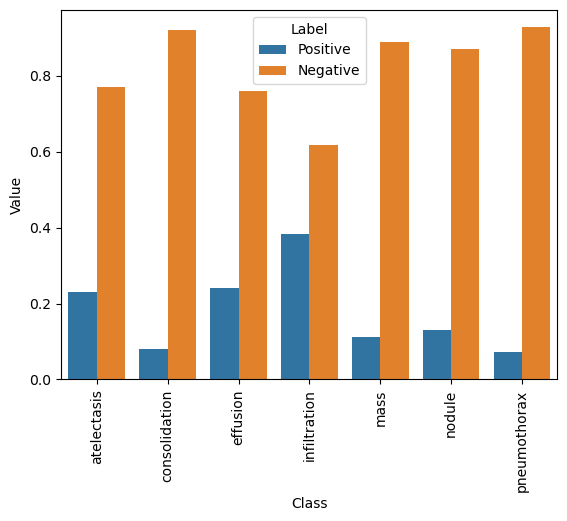

In [41]:
import seaborn as sns
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_dataset.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_29/1490179493.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


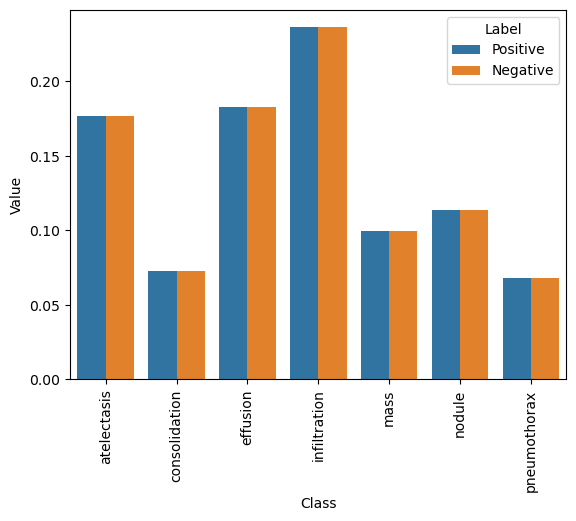

In [42]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [43]:
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()

    def forward(self, y_pred, y_true):
#         y_true = torch.LongTensor(y_true)
        loss = 0.0
        epsilon = 1e-9
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * torch.mean(neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            loss += (loss_pos + loss_neg)
        return loss

# Training DenseNet121

In [70]:
densenet = torchvision.models.densenet121(pretrained=True)
for param in densenet.parameters():
    param.requires_grad = False
densenet.classifier = nn.Linear(in_features=1024, out_features=7, bias=True)
densenet.to(DEVICE)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [71]:
with torch.no_grad():
        dn_accuracies_pretrained, dn_precisions_pretrained, dn_recalls_pretrained, dn_f1_pretrained = get_classes_accuracy_and_pr(test_loader, densenet)
        print(f'accuracies: {dn_accuracies_pretrained}')
        print(f'mean accuracy: {np.mean(dn_accuracies_pretrained)}\n')
        
        print(f'precisions: {dn_precisions_pretrained}')
        print(f'mean precision: {np.mean(dn_precisions_pretrained)}\n')
        
        print(f'recalls: {dn_recalls_pretrained}')
        print(f'mean recall: {np.mean(dn_recalls_pretrained)}\n')
        
        print(f'f1: {dn_f1_pretrained}')
        print(f'mean f1: {np.mean(dn_f1_pretrained)}\n')

100%|██████████| 981/981 [01:57<00:00,  8.36it/s]


accuracies: [0.4954264091004648, 0.4806081581552055, 0.48923395128694763, 0.49660748921336584, 0.5001258357837169, 0.48072031982134933, 0.48336946314996776]
mean accuracy: 0.4894416609301454

precisions: [0.17883211678832117, 0.11015736766809728, 0.2913149234511375, 0.386515092120737, 0.10918034881492365, 0.09867814325238242, 0.16079188797682278]
mean precision: 0.19078141143891741

recalls: [0.04516129032258064, 0.6787878787878788, 0.8760757314974182, 0.9717477003942181, 0.9982476635514018, 0.795046439628483, 0.5005636978579482]
mean recall: 0.6950900574342755

f1: [0.07211184694628403, 0.189553042541734, 0.43723826908622365, 0.5530522576423297, 0.19683270947307804, 0.17556573460039654, 0.24339881224303336]
mean f1: 0.2668218103618684



In [61]:
dn_losses = []

dn_class_accuracies_by_epochs = []
dn_mean_accuracies_by_epochs = []

dn_class_precs_by_epochs = []
dn_mean_precs_by_epochs = []

dn_class_recs_by_epochs = []
dn_mean_recs_by_epochs = []

dn_class_f1_by_epochs = []
dn_mean_f1_by_epochs = []

In [62]:
optimizer = optim.Adam(densenet.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
loss_fn = WeightedLoss()

In [63]:
for epoch in range(25):
    loss = train_epoch(
        train_loader,
        densenet,
        optimizer,
        loss_fn,
        epoch + 1
    )
    
    with torch.no_grad():
        dn_accs, dn_precs, dn_recs, dn_f1 = get_classes_accuracy_and_pr(test_loader, densenet)
        print(f'epoch {epoch + 1} classes balanced accuracies:')
        print(f'accuracies: {dn_accs}')
        print(f'mean accuracy: {np.mean(dn_accs)}\n')
        
        print(f'precisions: {dn_precs}')
        print(f'mean precision: {np.mean(dn_precs)}\n')
        
        print(f'recalls: {dn_recs}')
        print(f'mean recall: {np.mean(dn_recs)}\n')
        
        print(f'f1: {dn_f1}')
        print(f'mean f1: {np.mean(dn_f1)}\n')
        
        dn_class_accuracies_by_epochs.append(dn_accs)
        dn_mean_accuracies_by_epochs.append(np.mean(dn_accs))
        
        dn_class_precs_by_epochs.append(dn_precs)
        dn_mean_precs_by_epochs.append(np.mean(dn_precs))
        
        dn_class_recs_by_epochs.append(dn_recs)
        dn_mean_recs_by_epochs.append(np.mean(dn_recs))
        
        dn_class_f1_by_epochs.append(dn_f1)
        dn_mean_f1_by_epochs.append(np.mean(dn_f1))
        
        torch.save(dn_class_accuracies_by_epochs, './dn_class_accuracies_by_epochs.pt')
        torch.save(dn_mean_accuracies_by_epochs, './dn_mean_accuracies_by_epochs.pt')
        torch.save(dn_class_precs_by_epochs, './dn_class_precs_by_epochs.pt')
        torch.save(dn_mean_precs_by_epochs, './dn_mean_precs_by_epochs.pt')
        torch.save(dn_class_recs_by_epochs, './dn_class_recs_by_epochs.pt')
        torch.save(dn_mean_recs_by_epochs, './dn_mean_recs_by_epochs.pt')
        torch.save(dn_class_f1_by_epochs, './dn_class_f1_by_epochs.pt')
        torch.save(dn_mean_f1_by_epochs, './dn_mean_f1_by_epochs.pt')
    
        if len(dn_mean_f1_by_epochs) == 1 or dn_mean_f1_by_epochs[-1] > dn_mean_f1_by_epochs[-2]:
            torch.save(densenet.state_dict(), f'./dn_weights_f1_{np.mean(dn_f1)}.pt')
        
    dn_losses.append(loss)

 18%|█▊        | 200/1126 [00:50<03:49,  4.03it/s]

  batch 200 loss: 1.4694039225578308


 36%|███▌      | 400/1126 [01:41<03:02,  3.98it/s]

  batch 400 loss: 1.438578113913536


 53%|█████▎    | 600/1126 [02:32<02:10,  4.02it/s]

  batch 600 loss: 1.4242715030908584


 71%|███████   | 800/1126 [03:22<01:22,  3.97it/s]

  batch 800 loss: 1.4183269953727722


 89%|████████▉ | 1000/1126 [04:12<00:31,  4.03it/s]

  batch 1000 loss: 1.409510708451271


100%|██████████| 1126/1126 [04:44<00:00,  3.95it/s]


=> Epoch[1]: Mean Loss = 1.428948102687646


100%|██████████| 981/981 [01:53<00:00,  8.64it/s]


epoch 1 classes balanced accuracies:
accuracies: [0.5406592950261634, 0.5000360516259283, 0.5811815844125219, 0.5264727172239418, 0.5022787564447988, 0.5439827194013054, 0.5]
mean accuracy: 0.5278015891620943

precisions: [0.22689928920889874, 0.1157304087228209, 0.34548482605477426, 0.5500821018062397, 0.10960133316241508, 0.11246925542222554, 0.16966335118592196]
mean precision: 0.23284722365189944

recalls: [0.7551459293394778, 1.0, 0.8033562822719449, 0.11005256241787122, 0.9988317757009346, 0.9343653250773993, 1.0]
mean recall: 0.800250267829661

f1: [0.3489494605337876, 0.20745228026060122, 0.48317805383022777, 0.1834108951546674, 0.19752801201339956, 0.20077168706758916, 0.2901062959934587]
mean f1: 0.27305666926481875



 18%|█▊        | 200/1126 [00:49<03:48,  4.05it/s]

  batch 200 loss: 1.3974974077939988


 36%|███▌      | 400/1126 [01:38<02:55,  4.14it/s]

  batch 400 loss: 1.390317634344101


 53%|█████▎    | 600/1126 [02:27<02:14,  3.91it/s]

  batch 600 loss: 1.3803202974796296


 71%|███████   | 800/1126 [03:15<01:21,  4.01it/s]

  batch 800 loss: 1.382410747408867


 89%|████████▉ | 1000/1126 [04:04<00:29,  4.21it/s]

  batch 1000 loss: 1.3864805734157561


100%|██████████| 1126/1126 [04:35<00:00,  4.09it/s]


=> Epoch[2]: Mean Loss = 1.3860025067100727


100%|██████████| 981/981 [01:53<00:00,  8.64it/s]


epoch 2 classes balanced accuracies:
accuracies: [0.551663031271076, 0.49984560369788383, 0.5964967413796438, 0.5517794043619796, 0.5093990551195849, 0.5607306492745726, 0.5008487282192005]
mean accuracy: 0.5386804590462774

precisions: [0.23346303501945526, 0.11569140450513687, 0.3577473008462212, 0.5301914580265096, 0.1110452089099776, 0.11697302458820721, 0.16990291262135923]
mean precision: 0.23357347778812382

recalls: [0.7373271889400922, 0.9988980716253444, 0.7913080895008606, 0.23653088042049936, 0.9842289719626168, 0.9102167182662538, 0.9996242014280345]
mean recall: 0.8083048745919574

f1: [0.3546361285555966, 0.20736589271417133, 0.4927322660593475, 0.3271240345297592, 0.1995736112756129, 0.2073050345508391, 0.29044057432985754]
mean f1: 0.2970253631450263



 18%|█▊        | 200/1126 [00:48<03:48,  4.06it/s]

  batch 200 loss: 1.3772121918201448


 36%|███▌      | 400/1126 [01:37<02:53,  4.19it/s]

  batch 400 loss: 1.3752548855543136


 53%|█████▎    | 600/1126 [02:26<02:06,  4.14it/s]

  batch 600 loss: 1.373948376774788


 71%|███████   | 800/1126 [03:15<01:19,  4.10it/s]

  batch 800 loss: 1.366140387058258


 89%|████████▉ | 1000/1126 [04:04<00:29,  4.22it/s]

  batch 1000 loss: 1.3649121046066284


100%|██████████| 1126/1126 [04:34<00:00,  4.10it/s]


=> Epoch[3]: Mean Loss = 1.3696545808184


100%|██████████| 981/981 [01:53<00:00,  8.66it/s]


epoch 3 classes balanced accuracies:
accuracies: [0.5571020724906408, 0.5021787695848223, 0.5998073352801253, 0.5605110731091963, 0.5097280676172103, 0.5646836346383932, 0.5028835896182636]
mean accuracy: 0.5424135060483789

precisions: [0.23542218856493752, 0.11617165950349606, 0.3586003051106026, 0.5271270036991369, 0.11111846021562273, 0.11778656126482213, 0.17048003589053387]
mean precision: 0.23381517346416453

recalls: [0.7640552995391705, 0.9977961432506887, 0.8091652323580034, 0.280880420499343, 0.9813084112149533, 0.9226006191950464, 0.9996242014280345]
mean recall: 0.8222043324978914

f1: [0.3599392141254794, 0.208113077453459, 0.49696088794926, 0.3664809258465495, 0.19963163210742083, 0.20890290921836663, 0.2912833990363557]
mean f1: 0.3044731493909844



 18%|█▊        | 200/1126 [00:48<03:41,  4.18it/s]

  batch 200 loss: 1.3622962599992752


 36%|███▌      | 400/1126 [01:37<02:52,  4.22it/s]

  batch 400 loss: 1.3553655707836152


 53%|█████▎    | 600/1126 [02:26<02:09,  4.05it/s]

  batch 600 loss: 1.352969474196434


 71%|███████   | 800/1126 [03:15<01:22,  3.96it/s]

  batch 800 loss: 1.355987691283226


 89%|████████▉ | 1000/1126 [04:04<00:31,  4.05it/s]

  batch 1000 loss: 1.35977658867836


100%|██████████| 1126/1126 [04:35<00:00,  4.08it/s]


=> Epoch[4]: Mean Loss = 1.3558659292029658


100%|██████████| 981/981 [01:53<00:00,  8.61it/s]


epoch 4 classes balanced accuracies:
accuracies: [0.5683779906736623, 0.5025753374700339, 0.6068742166927951, 0.545166411596159, 0.5131485434152685, 0.5791674689560761, 0.5078183157177212]
mean accuracy: 0.5461611835031023

precisions: [0.24672295045545434, 0.11625369110283733, 0.36781844203639336, 0.5469561113732893, 0.11185006045949214, 0.1231826592651335, 0.17190029135642604]
mean precision: 0.24066917229271798

recalls: [0.6823348694316437, 0.9977961432506887, 0.7740963855421686, 0.19037450722733246, 0.9725467289719626, 0.8656346749226006, 0.9977452085682075]
mean recall: 0.782932645416372

f1: [0.3624051562372522, 0.20824469614212615, 0.49868329868329864, 0.2824418179602778, 0.20062658151584528, 0.21567417463745758, 0.2932729481939689]
mean f1: 0.2944783819100323



 18%|█▊        | 200/1126 [00:49<03:47,  4.06it/s]

  batch 200 loss: 1.346137015223503


 36%|███▌      | 400/1126 [01:37<02:53,  4.18it/s]

  batch 400 loss: 1.3489707207679749


 53%|█████▎    | 600/1126 [02:27<02:08,  4.09it/s]

  batch 600 loss: 1.3532886946201323


 71%|███████   | 800/1126 [03:15<01:18,  4.15it/s]

  batch 800 loss: 1.351648662686348


 89%|████████▉ | 1000/1126 [04:05<00:30,  4.13it/s]

  batch 1000 loss: 1.3476156800985337


100%|██████████| 1126/1126 [04:36<00:00,  4.07it/s]


=> Epoch[5]: Mean Loss = 1.349146840839149


100%|██████████| 981/981 [01:54<00:00,  8.56it/s]


epoch 5 classes balanced accuracies:
accuracies: [0.5722113772124284, 0.5039452992553104, 0.6059183401654046, 0.556263758881137, 0.5228038687521906, 0.5835175683225993, 0.510962523074041]
mean accuracy: 0.5508032479518731

precisions: [0.24783643444396367, 0.11653796653796654, 0.3635129895308259, 0.5369056068133428, 0.11399360133537349, 0.124359200989924, 0.17281540763875333]
mean precision: 0.23942302961287854

recalls: [0.7038402457757297, 0.9977961432506887, 0.8067986230636833, 0.24852168199737187, 0.9573598130841121, 0.8712074303405573, 0.9981210071401728]
mean recall: 0.7976635635217594

f1: [0.3665893271461717, 0.2087006626332469, 0.5012028869286287, 0.33977094093869303, 0.20372902423865755, 0.21765024363833244, 0.29462007764836384]
mean f1: 0.3046090233102992



 18%|█▊        | 200/1126 [00:49<03:40,  4.20it/s]

  batch 200 loss: 1.3446163320541382


 36%|███▌      | 400/1126 [01:38<02:56,  4.12it/s]

  batch 400 loss: 1.3381887263059615


 53%|█████▎    | 600/1126 [02:27<02:03,  4.25it/s]

  batch 600 loss: 1.3427057844400405


 71%|███████   | 800/1126 [03:16<01:21,  4.02it/s]

  batch 800 loss: 1.3397659450769424


 89%|████████▉ | 1000/1126 [04:04<00:30,  4.10it/s]

  batch 1000 loss: 1.3433529847860337


100%|██████████| 1126/1126 [04:35<00:00,  4.09it/s]


=> Epoch[6]: Mean Loss = 1.3412544966590976


100%|██████████| 981/981 [01:53<00:00,  8.64it/s]


epoch 6 classes balanced accuracies:
accuracies: [0.5796197239027353, 0.5048983135585696, 0.6149603722194739, 0.5556183341832641, 0.5282064462703779, 0.5856629873949423, 0.5196417733225606]
mean accuracy: 0.5555154215502748

precisions: [0.255420844019585, 0.11673880741649978, 0.37928752619388995, 0.5416821044831419, 0.11530218602657523, 0.12559241706161137, 0.17541766109785203]
mean precision: 0.2442059351855936

recalls: [0.6731182795698925, 0.9955922865013774, 0.7398881239242685, 0.24014454664914586, 0.9427570093457944, 0.853250773993808, 0.9943630214205186]
mean recall: 0.7770162916292579

f1: [0.37032029071241446, 0.2089742107089164, 0.5014947138169887, 0.33276431091385, 0.20547422024188416, 0.21895606578215618, 0.29822485207100596]
mean f1: 0.30517266632103085



 18%|█▊        | 200/1126 [00:48<03:39,  4.22it/s]

  batch 200 loss: 1.3395651268959046


 36%|███▌      | 400/1126 [01:37<02:51,  4.23it/s]

  batch 400 loss: 1.338558040857315


 53%|█████▎    | 600/1126 [02:26<02:09,  4.07it/s]

  batch 600 loss: 1.3370548969507217


 71%|███████   | 800/1126 [03:15<01:20,  4.06it/s]

  batch 800 loss: 1.3378300231695175


 89%|████████▉ | 1000/1126 [04:03<00:29,  4.25it/s]

  batch 1000 loss: 1.3364066624641417


100%|██████████| 1126/1126 [04:34<00:00,  4.11it/s]


=> Epoch[7]: Mean Loss = 1.3376690985677933


100%|██████████| 981/981 [01:53<00:00,  8.65it/s]


epoch 7 classes balanced accuracies:
accuracies: [0.5778589763126447, 0.5022638037504417, 0.6127136178951814, 0.5698273316904383, 0.520655546741012, 0.5753660365201405, 0.516101423541612]
mean accuracy: 0.5535409623502101

precisions: [0.24950370912130393, 0.11618949801001412, 0.3732401710293044, 0.524986849026828, 0.11350307044780239, 0.12143763213530655, 0.17434816960758492]
mean precision: 0.2390298713397349

recalls: [0.7336405529953917, 0.9972451790633609, 0.7700086058519794, 0.3278580814717477, 0.9608644859813084, 0.8891640866873065, 0.9951146185644495]
mean recall: 0.8105565158022205

f1: [0.3723686262279744, 0.20812970735353303, 0.502774460911709, 0.4036400404448939, 0.20302375809935205, 0.21369047619047618, 0.2967113003529609]
mean f1: 0.3143340527972714



 18%|█▊        | 200/1126 [00:48<03:45,  4.12it/s]

  batch 200 loss: 1.33539688706398


 36%|███▌      | 400/1126 [01:38<03:09,  3.83it/s]

  batch 400 loss: 1.3363681161403655


 53%|█████▎    | 600/1126 [02:27<02:11,  3.99it/s]

  batch 600 loss: 1.324349924325943


 71%|███████   | 800/1126 [03:16<01:23,  3.88it/s]

  batch 800 loss: 1.3267400002479552


 89%|████████▉ | 1000/1126 [04:05<00:30,  4.07it/s]

  batch 1000 loss: 1.3226142019033431


100%|██████████| 1126/1126 [04:36<00:00,  4.07it/s]


=> Epoch[8]: Mean Loss = 1.329455116608215


100%|██████████| 981/981 [01:52<00:00,  8.69it/s]


epoch 8 classes balanced accuracies:
accuracies: [0.5797519774067857, 0.5041051777881463, 0.6139006265833801, 0.5670298865219247, 0.5277746748503683, 0.5785208768724335, 0.5247120241085909]
mean accuracy: 0.5565421777330899

precisions: [0.25397900440230275, 0.11657312431456035, 0.3721758599633625, 0.5283548568220101, 0.1151558073654391, 0.12268237740426269, 0.17699590411602767]
mean precision: 0.24084527634113786

recalls: [0.6912442396313364, 0.9955922865013774, 0.7867900172117039, 0.3091327201051248, 0.9497663551401869, 0.8767801857585139, 0.9906050357008643]
mean recall: 0.7999872628641581

f1: [0.37147102526002973, 0.20870870870870872, 0.5053198839298052, 0.39005181347150264, 0.2054067710965134, 0.21524663677130043, 0.3003304090235844]
mean f1: 0.3137907497516349



 18%|█▊        | 200/1126 [00:50<03:52,  3.99it/s]

  batch 200 loss: 1.3310316067934036


 36%|███▌      | 400/1126 [01:41<03:01,  4.00it/s]

  batch 400 loss: 1.332983312010765


 53%|█████▎    | 600/1126 [02:31<02:11,  4.01it/s]

  batch 600 loss: 1.3292706501483917


 71%|███████   | 800/1126 [03:22<01:22,  3.95it/s]

  batch 800 loss: 1.3301309007406235


 89%|████████▉ | 1000/1126 [04:13<00:31,  4.00it/s]

  batch 1000 loss: 1.3288086664676666


100%|██████████| 1126/1126 [04:45<00:00,  3.95it/s]


=> Epoch[9]: Mean Loss = 1.3309940846097617


100%|██████████| 981/981 [01:53<00:00,  8.63it/s]


epoch 9 classes balanced accuracies:
accuracies: [0.5822349099567571, 0.5048853826448069, 0.6136341305781299, 0.5559970372017687, 0.537293796538337, 0.5898095564826782, 0.5303965726754702]
mean accuracy: 0.5591787694397069

precisions: [0.2564575645756458, 0.11673553719008264, 0.37166886209342387, 0.5352609308885754, 0.11753868828297716, 0.12776295731707318, 0.1788097507830587]
mean precision: 0.2434620415901195

recalls: [0.6832565284178187, 0.9961432506887052, 0.7891566265060241, 0.24934296977660972, 0.9316588785046729, 0.8303405572755418, 0.9868470499812101]
mean recall: 0.7809636944500832

f1: [0.37293535675358436, 0.20898110154308502, 0.5053385685747744, 0.34020618556701027, 0.20874231121580944, 0.22145157295021056, 0.30276128437193756]
mean f1: 0.3086309115680588



 18%|█▊        | 200/1126 [00:50<03:48,  4.06it/s]

  batch 200 loss: 1.333417581319809


 36%|███▌      | 400/1126 [01:41<03:02,  3.97it/s]

  batch 400 loss: 1.3249950575828553


 53%|█████▎    | 600/1126 [02:32<02:16,  3.86it/s]

  batch 600 loss: 1.3244145393371582


 71%|███████   | 800/1126 [03:22<01:22,  3.97it/s]

  batch 800 loss: 1.3268261367082597


 89%|████████▉ | 1000/1126 [04:13<00:31,  4.03it/s]

  batch 1000 loss: 1.3233222764730455


100%|██████████| 1126/1126 [04:45<00:00,  3.95it/s]


=> Epoch[10]: Mean Loss = 1.3260467806252028


100%|██████████| 981/981 [01:53<00:00,  8.68it/s]


epoch 10 classes balanced accuracies:
accuracies: [0.5808428556227019, 0.5060778274158017, 0.6178606753425965, 0.5545998894085852, 0.5360216427514575, 0.575417309690167, 0.5334599240386513]
mean accuracy: 0.5577543034671372

precisions: [0.2522232936890603, 0.11698749108821051, 0.3827617126204887, 0.5291060291060291, 0.11718293395675043, 0.12152866242038217, 0.17977835545218224]
mean precision: 0.24279549690472907

recalls: [0.723195084485407, 0.9944903581267218, 0.7347246127366609, 0.25082128777923784, 0.9369158878504673, 0.8860681114551083, 0.9875986471251409]
mean recall: 0.7876877127941064

f1: [0.3740069907848744, 0.2093481790767803, 0.503316138540899, 0.3403164698016492, 0.20831168831168828, 0.21374159820761762, 0.30418426992302794]
mean f1: 0.3076036192352195



 18%|█▊        | 200/1126 [00:48<03:39,  4.22it/s]

  batch 200 loss: 1.3298353415727615


 36%|███▌      | 400/1126 [01:37<02:54,  4.16it/s]

  batch 400 loss: 1.3193383532762528


 53%|█████▎    | 600/1126 [02:26<02:05,  4.17it/s]

  batch 600 loss: 1.31538368165493


 71%|███████   | 800/1126 [03:14<01:19,  4.12it/s]

  batch 800 loss: 1.3153316152095795


 89%|████████▉ | 1000/1126 [04:03<00:30,  4.17it/s]

  batch 1000 loss: 1.3141771626472474


100%|██████████| 1126/1126 [04:34<00:00,  4.11it/s]


=> Epoch[11]: Mean Loss = 1.3192661305092157


100%|██████████| 981/981 [01:52<00:00,  8.72it/s]


epoch 11 classes balanced accuracies:
accuracies: [0.5816985547031563, 0.5081327700937164, 0.615115318104604, 0.5643002600733222, 0.5345717302428622, 0.5801167707937461, 0.532964875862244]
mean accuracy: 0.559557182839093

precisions: [0.2529640008622548, 0.11742128545407234, 0.3757646066230753, 0.5256962388745334, 0.11682175050886885, 0.12345570067066713, 0.17962393162393162]
mean precision: 0.2416782163739148

recalls: [0.7210445468509985, 0.9944903581267218, 0.766566265060241, 0.30075558475689884, 0.9386682242990654, 0.8662538699690403, 0.9872228485531755]
mean recall: 0.7964288139451631

f1: [0.3745312375329131, 0.21004247396287892, 0.5043170559094127, 0.38261414690210016, 0.2077838117403672, 0.21611184058082952, 0.3039453893324077]
mean f1: 0.31419227942298705



 18%|█▊        | 200/1126 [00:50<03:49,  4.04it/s]

  batch 200 loss: 1.3269193357229232


 36%|███▌      | 400/1126 [01:40<03:01,  4.00it/s]

  batch 400 loss: 1.3168362778425218


 53%|█████▎    | 600/1126 [02:31<02:17,  3.83it/s]

  batch 600 loss: 1.3274400877952575


 71%|███████   | 800/1126 [03:22<01:20,  4.04it/s]

  batch 800 loss: 1.31949800491333


 89%|████████▉ | 1000/1126 [04:12<00:31,  4.02it/s]

  batch 1000 loss: 1.3251786565780639


100%|██████████| 1126/1126 [04:44<00:00,  3.96it/s]


=> Epoch[12]: Mean Loss = 1.3222965731502214


100%|██████████| 981/981 [01:51<00:00,  8.79it/s]


epoch 12 classes balanced accuracies:
accuracies: [0.5853875635730766, 0.5080708566402626, 0.6178966630255294, 0.5624221163110561, 0.5380510687596822, 0.578044542521192, 0.5440285987820872]
mean accuracy: 0.5619859156589838

precisions: [0.2582278481012658, 0.11740627639529595, 0.37889328909343895, 0.5306372549019608, 0.11771647735654227, 0.12268922218346703, 0.18329596412556054]
mean precision: 0.24412376173679015

recalls: [0.6894009216589861, 0.9955922865013774, 0.7616179001721171, 0.2844940867279895, 0.9322429906542056, 0.8712074303405573, 0.9830890642615558]
mean recall: 0.7882349543309698

f1: [0.37572205943909587, 0.21004300825293504, 0.506039596883711, 0.3704020530367836, 0.2090373280943026, 0.21508828250401285, 0.30898246028465126]
mean f1: 0.3136163983564989



 18%|█▊        | 200/1126 [00:48<04:31,  3.41it/s]

  batch 200 loss: 1.316249828338623


 36%|███▌      | 400/1126 [01:36<02:54,  4.16it/s]

  batch 400 loss: 1.3213634651899338


 53%|█████▎    | 600/1126 [02:25<02:11,  4.00it/s]

  batch 600 loss: 1.3175459790229798


 71%|███████   | 800/1126 [03:14<01:23,  3.92it/s]

  batch 800 loss: 1.3176491397619248


 89%|████████▉ | 1000/1126 [04:02<00:30,  4.18it/s]

  batch 1000 loss: 1.3156337463855743


100%|██████████| 1126/1126 [04:33<00:00,  4.12it/s]


=> Epoch[13]: Mean Loss = 1.3176840559627405


100%|██████████| 981/981 [01:52<00:00,  8.74it/s]


epoch 13 classes balanced accuracies:
accuracies: [0.5875746220096971, 0.5057145700411585, 0.6185704475854019, 0.5641449035104968, 0.5357631150150769, 0.5919685970538393, 0.5473345181246846]
mean accuracy: 0.5644386819057651

precisions: [0.2595921189077083, 0.11690914969285483, 0.37934724451578383, 0.5279321439017256, 0.1172291296625222, 0.1288194781259094, 0.18441466854724964]
mean precision: 0.24489199047910767

recalls: [0.6921658986175115, 0.9961432506887052, 0.7626936316695353, 0.296484888304862, 0.9252336448598131, 0.8222910216718267, 0.9827132656895904]
mean recall: 0.7825322287859777

f1: [0.3775766716943188, 0.20925925925925926, 0.5066819123847638, 0.3797202061638793, 0.20809248554913293, 0.22274404562227443, 0.3105516299507155]
mean f1: 0.3163751729463348



 18%|█▊        | 200/1126 [00:50<03:53,  3.97it/s]

  batch 200 loss: 1.3166479974985124


 36%|███▌      | 400/1126 [01:40<03:00,  4.01it/s]

  batch 400 loss: 1.3115804731845855


 53%|█████▎    | 600/1126 [02:31<02:11,  4.00it/s]

  batch 600 loss: 1.3119251710176467


 71%|███████   | 800/1126 [03:21<01:20,  4.07it/s]

  batch 800 loss: 1.314953726530075


 89%|████████▉ | 1000/1126 [04:12<00:31,  4.06it/s]

  batch 1000 loss: 1.3162197542190552


100%|██████████| 1126/1126 [04:43<00:00,  3.97it/s]


=> Epoch[14]: Mean Loss = 1.3128736854446506


100%|██████████| 981/981 [01:53<00:00,  8.67it/s]


epoch 14 classes balanced accuracies:
accuracies: [0.5856803973759896, 0.5079913047053629, 0.6193501677189782, 0.5727485348965485, 0.5352424642342094, 0.5747482498354528, 0.5536979453834214]
mean accuracy: 0.5642084377357091

precisions: [0.25772025431425977, 0.11739413680781759, 0.378211177519136, 0.5259278088459584, 0.11705489014622676, 0.1215025241721571, 0.18664567379947042]
mean precision: 0.24349378080071798

recalls: [0.6973886328725039, 0.9928374655647383, 0.7760327022375215, 0.3398488830486202, 0.9304906542056075, 0.8792569659442725, 0.9800826756858324]
mean recall: 0.7994197113655852

f1: [0.3763574566857332, 0.20996213224584911, 0.5085653859710964, 0.4128916383955298, 0.20794987272371257, 0.21350172906329876, 0.31357460622820726]
mean f1: 0.3204004030447753



 18%|█▊        | 200/1126 [00:50<03:49,  4.04it/s]

  batch 200 loss: 1.3085775637626649


 36%|███▌      | 400/1126 [01:40<02:58,  4.08it/s]

  batch 400 loss: 1.3196256881952286


 53%|█████▎    | 600/1126 [02:30<02:13,  3.95it/s]

  batch 600 loss: 1.3090322011709212


 71%|███████   | 800/1126 [03:20<01:25,  3.81it/s]

  batch 800 loss: 1.314130676984787


 89%|████████▉ | 1000/1126 [04:11<00:31,  3.95it/s]

  batch 1000 loss: 1.3173196113109589


100%|██████████| 1126/1126 [04:43<00:00,  3.98it/s]


=> Epoch[15]: Mean Loss = 1.3131968583349225


100%|██████████| 981/981 [01:52<00:00,  8.70it/s]


epoch 15 classes balanced accuracies:
accuracies: [0.5889383495489403, 0.5087585786482607, 0.6182790760203346, 0.572590473801228, 0.5355541690858352, 0.5847089103307075, 0.5549468847977834]
mean accuracy: 0.56625377746187

precisions: [0.26175844953911603, 0.11755506320865372, 0.37656817003628823, 0.5261546312834907, 0.11717306128483773, 0.12536496350364965, 0.1871181079721084]
mean precision: 0.24452749240402064

recalls: [0.6804915514592934, 0.9939393939393939, 0.7814113597246127, 0.33869908015768724, 0.9258177570093458, 0.8507739938080495, 0.9782036828260052]
mean recall: 0.792762402703484

f1: [0.37808312708031067, 0.2102441582658353, 0.508220807388232, 0.41211152193464573, 0.2080188988778791, 0.21852882703777338, 0.31414433985034995]
mean f1: 0.32133595434786094



 18%|█▊        | 200/1126 [00:50<03:53,  3.96it/s]

  batch 200 loss: 1.3053001588582993


 36%|███▌      | 400/1126 [01:41<03:00,  4.03it/s]

  batch 400 loss: 1.3033420193195342


 53%|█████▎    | 600/1126 [02:31<02:10,  4.03it/s]

  batch 600 loss: 1.3170439475774764


 71%|███████   | 800/1126 [03:21<01:20,  4.06it/s]

  batch 800 loss: 1.3080962777137757


 89%|████████▉ | 1000/1126 [04:12<00:31,  4.03it/s]

  batch 1000 loss: 1.3120708107948302


 92%|█████████▏| 1035/1126 [04:21<00:22,  3.96it/s]


KeyboardInterrupt: 

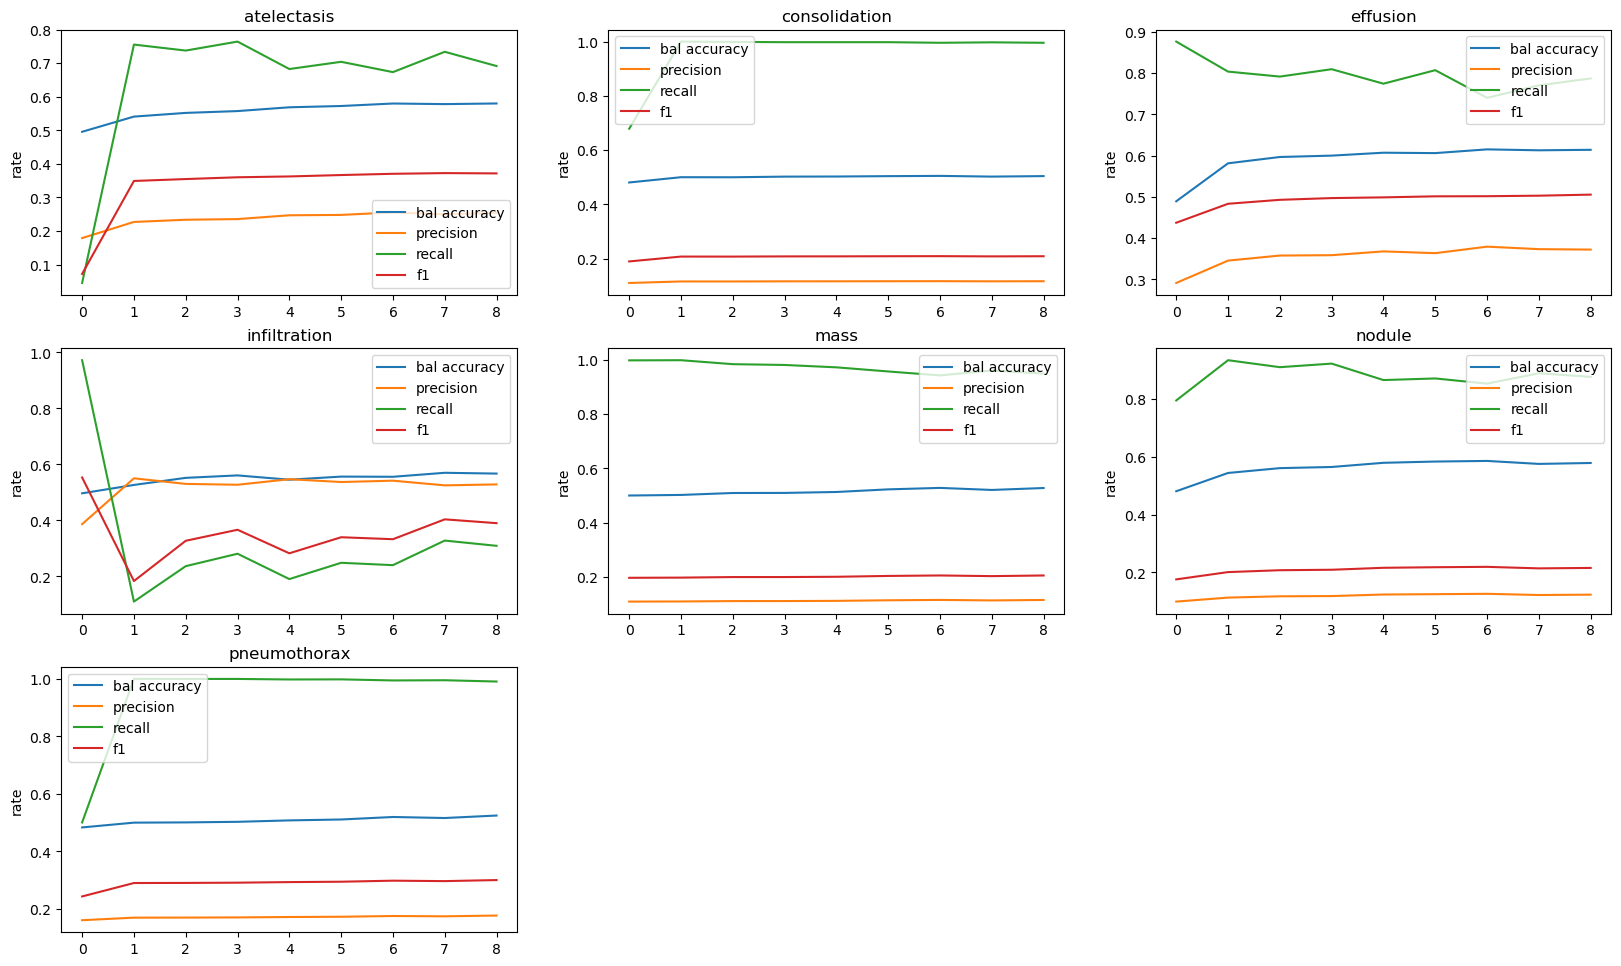

In [82]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,20))
for i in range(7):
    plt.subplot(5, 3, i + 1)
    plt.plot(range(9), [dn_accuracies_pretrained[i], *np.array(dn_class_accuracies_by_epochs[:8])[:, i]],
             label='bal accuracy')
    plt.plot(range(9), [dn_precisions_pretrained[i], *np.array(dn_class_precs_by_epochs[:8])[:, i]],
             label='precision')
    plt.plot(range(9), [dn_recalls_pretrained[i], *np.array(dn_class_recs_by_epochs[:8])[:, i]],
             label='recall')
    plt.plot(range(9), [dn_f1_pretrained[i], *np.array(dn_class_f1_by_epochs[:8])[:, i]],
             label='f1')
    plt.legend()
#     plt.plot(range(1, 11), np.array(class_accuracies_by_epochs)[:, i])
    plt.xticks(ticks=range(9))
    plt.title(labels[i])
#     plt.xlabel('epoch')
    plt.ylabel('rate')